## Import

In [129]:
%env TF_CPP_MIN_LOG_LEVEL=3
import matplotlib.pyplot as plt
import json
import pydicom as pdc
import numpy as np
import pathlib
import sys
import tensorflow as tf
import h5py
import pandas as pd

from pprint import pprint
sys.path.append(pathlib.Path.cwd().parent.as_posix())
from src.data.preprocess.lib.utils import string_to_int_tuple, convert_num_to_abr
from src.data.preprocess.lib.tfrecord import parsed_example_fn
import tensorflow as tf
import numpy as np
from keras.utils.layer_utils import count_params
from matplotlib import pyplot as plt

from src.models.lib.base import base_unet_pp
from src.models.lib.builder import build_unet_pp
from src.models.lib.config import UNetPPConfig
from src.models.lib.loss import log_cosh_dice_loss_func
from src.models.lib.utils import loss_dict_gen
from src.models.train_model import create_dataset
from src.models.lib.data_loader import preprocess_img

env: TF_CPP_MIN_LOG_LEVEL=3


## Model Loading

In [3]:
project_root = pathlib.Path.cwd().parent
model_paths = list((project_root / "models"/ "trained_model").rglob("model*"))
float_model = tf.keras.models.load_model(model_paths[0].as_posix(),custom_objects={"log_cosh_dice_loss_func":log_cosh_dice_loss_func})

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [5]:
# Model conversion from mixed precision to float32 
model = tf.keras.models.clone_model(
    float_model,
    clone_function=lambda layer: layer.__class__.from_config(
        {**layer.get_config(), "dtype": "float32"}
    ),
)

## Sample Loading

In [10]:
sample_patient_index = 3
sample_patient_image_index = 1
raw_json_path = list(project_root_path.rglob("raw*.json"))[0]
with raw_json_path.open(mode="r") as json_file:
    raw_dict_output = json.load(json_file)
sample_patient_raw_dict = raw_dict_output[str(sample_patient_index).zfill(3)]
sample_image_with_roi = sample_patient_raw_dict["Images"][sample_patient_image_index]

sample_image_index = sample_image_with_roi["ImageIndex"]
project_root_path = pathlib.Path.cwd().parent

sample_image_patient_path = list(project_root_path.rglob(f"patient/{sample_patient_index}"))[0]
sample_image_path = list(sample_image_patient_path.rglob(f"*00{str(sample_image_index).zfill(2)}.dcm"))[0]
sample_image_dcm = pdc.dcmread(sample_image_path)
sample_image_array = sample_image_dcm.pixel_array
sample_image_hu= pdc.pixel_data_handlers.util.apply_modality_lut(
    sample_image_array, sample_image_dcm
)

## Model Prediction

In [15]:
preprocessed_sample_img_hu = preprocess_img(sample_image_hu)
expanded_sample_img_hu = np.expand_dims(np.expand_dims(preprocessed_sample_img_hu,axis=0),axis=3)

In [16]:
output=model.predict(expanded_sample_img_hu)

1/1 [==============================] - 12s 12s/step


### Binary Seg

In [11]:
bin_seg_json_path = list(project_root_path.rglob("binary*.json"))[0]
with bin_seg_json_path.open(mode="r") as json_file:
    bin_seg_dict_output = json.load(json_file)
    
sample_patient_bin_seg_dict = bin_seg_dict_output[str(sample_patient_index).zfill(3)]
sample_image_with_bin_roi = sample_patient_bin_seg_dict[sample_patient_image_index]
sample_bin_roi = np.array(sample_image_with_bin_roi["pos"])

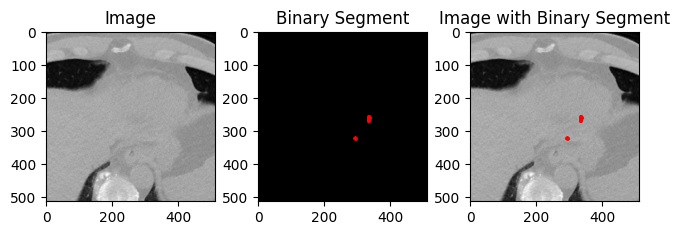

In [12]:
fig,ax=plt.subplots(1,3)
ax[0].set_title("Image")
ax[0].imshow(sample_image_array,cmap="gray",interpolation='none')
ax[1].set_title("Binary Segment")
ax[1].imshow(np.ones([512,512]),cmap="gray")
ax[1].scatter(sample_bin_roi[:,0],sample_bin_roi[:,1],color="r",marker='o', s=(72./fig.dpi)**2)
ax[2].set_title("Image with Binary Segment")
ax[2].imshow(sample_image_array,cmap="gray",interpolation='none')
ax[2].scatter(sample_bin_roi[:,0],sample_bin_roi[:,1],color="r",marker='o', s=(72./fig.dpi)**2)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

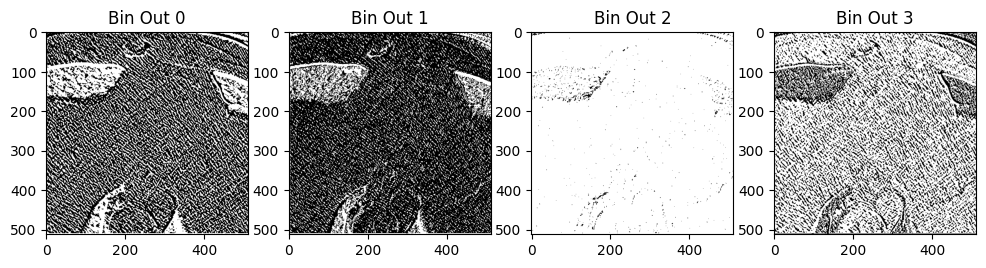

In [162]:
raw_bin_output= []
clipped_bin_output = []
bin_roi_coord = []
fig,ax = plt.subplots(1,4,figsize=(12,3))

for i in range(4):
    raw_bin_output.append(np.squeeze(output[i]))
    clipped_bin_output.append((raw_bin_output[i]>0.5)*1)
    bin_roi_coord.append(np.where(clipped_bin_output[i]==1))
    ax[i].set_title(f"Bin Out {i}")
    ax[i].imshow(clipped_bin_output[i],cmap="gray")
    


### Multiclass Seg

In [86]:
mult_seg_json_path = list(project_root_path.rglob("multi*.json"))[0]
with mult_seg_json_path.open(mode="r") as json_file:
    mult_seg_dict_output = json.load(json_file)
    
sample_patient_mult_seg_dict = mult_seg_dict_output[str(sample_patient_index).zfill(3)]
sample_image_with_mult_roi = sample_patient_mult_seg_dict[sample_patient_image_index]
sample_mult_roi = sample_image_with_mult_roi["roi"]

plot_mult_dict = {}

for mult_roi in sample_mult_roi:
    vessel_loc = convert_num_to_abr(mult_roi['loc'])
    vessel_pos=plot_mult_dict.get(vessel_loc,[])
    vessel_pos.extend(mult_roi["pos"])
    plot_mult_dict[vessel_loc]= vessel_pos

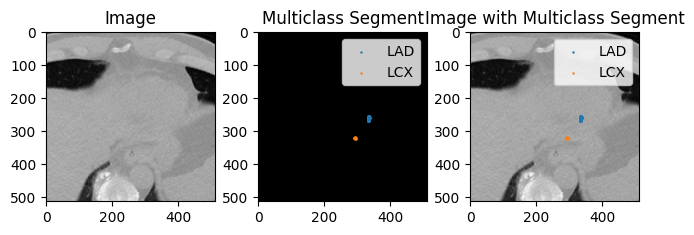

In [87]:
fig,ax=plt.subplots(1,3)
ax[0].set_title("Image")
ax[0].imshow(sample_image_array,cmap="gray",interpolation='none')
ax[1].set_title("Multiclass Segment")
ax[1].imshow(np.ones([512,512]),cmap="gray")
for loc, p in plot_mult_dict.items():
    ax[1].scatter(np.array(p)[:,0],np.array(p)[:,1],marker='o', s=(72./fig.dpi)**2,label=loc)
ax[1].legend()
ax[2].set_title("Image with Multiclass Segment")
ax[2].imshow(sample_image_array,cmap="gray",interpolation='none')
for loc, p in plot_mult_dict.items():
    ax[2].scatter(np.array(p)[:,0],np.array(p)[:,1],marker='o', s=(72./fig.dpi)**2,label=loc)
ax[2].legend()
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

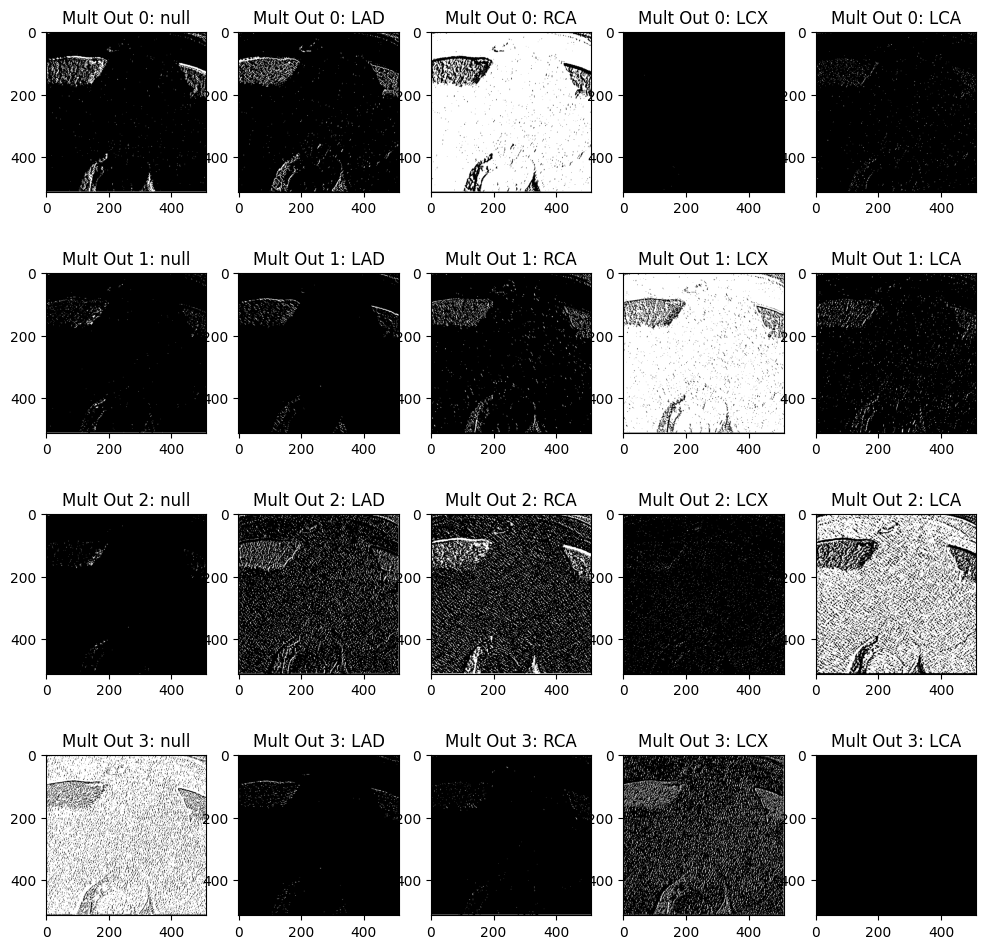

In [159]:
raw_mult_output= []
clipped_mult_output = []
mult_roi_coord = []
fig,ax = plt.subplots(4,5,figsize=(12,12))

for e,i in enumerate(range(4,8)):
    raw_mult_output.append(np.squeeze(output[i]))
    argmax = tf.argmax(raw_mult_output[e],axis=2)
    one_hot = tf.one_hot(argmax, depth=5, dtype=tf.float32)
    clipped_mult_output.append(one_hot)
    mult_roi_coord.append(np.where(clipped_mult_output[e]==1))
    for pi, t in zip(range(5),["null","LAD","RCA","LCX","LCA"]):
        ax[e][pi].set_title(f"Mult Out {e}: {t}")
        ax[e][pi].imshow(clipped_mult_output[e][:,:,pi],cmap="gray")

In [124]:
history = list((project_root / "models"/ "trained_model").rglob("history.csv"))[0]

In [132]:
df_history = pd.read_csv(history)
df_history

,epoch,loss,output_1_bin_c1_acc,output_1_bin_c1_loss,output_1_mult_c5_acc,output_1_mult_c5_loss,output_2_bin_c1_acc,output_2_bin_c1_loss,output_2_mult_c5_acc,output_2_mult_c5_loss,...,val_output_2_mult_c5_acc,val_output_2_mult_c5_loss,val_output_3_bin_c1_acc,val_output_3_bin_c1_loss,val_output_3_mult_c5_acc,val_output_3_mult_c5_loss,val_output_4_bin_c1_acc,val_output_4_bin_c1_loss,val_output_4_mult_c5_acc,val_output_4_mult_c5_loss
0,0,0.651152,0.953946,0.166213,0.991700,9.376018e-04,0.992558,0.136496,0.993346,1.062365e-03,...,0.999987,3.446303e-09,0.999987,0.061118,0.999987,1.312877e-09,0.999987,0.061118,0.999987,1.378521e-09
1,1,0.283318,0.999993,0.070829,0.999993,7.710099e-10,0.999993,0.070829,0.999993,1.356234e-09,...,0.999987,7.549046e-10,0.999987,0.061156,0.999987,7.220826e-10,0.999987,0.061156,0.999987,7.220826e-10
2,2,0.283499,0.999993,0.070875,0.999993,7.338528e-10,0.999993,0.070875,0.999993,7.802992e-10,...,0.999988,5.907949e-10,0.999988,0.061133,0.999988,6.564387e-10,0.999988,0.061133,0.999988,6.892607e-10


In [163]:
df_history.plot(x="epoch",y")

KeyError: 'acc'

In [153]:
loss_list = []
mult_loss_list = []
bin_loss_list = []
val_loss_list = []
val_mult_loss_list = []
val_bin_loss_list = []
for col_name in list(df_history.columns):
    if "loss" in col_name:
        
        if "val" not in col_name:
            loss_list.append(col_name)
            if "bin" not in col_name:
                mult_loss_list.append(col_name)
            else:
                bin_loss_list.append(col_name)
        else:
            val_loss_list.append(col_name)
            if "bin" not in col_name:
                mult_loss_list.append(col_name)
            else:
                bin_loss_list.append(col_name)

<Axes: xlabel='epoch'>

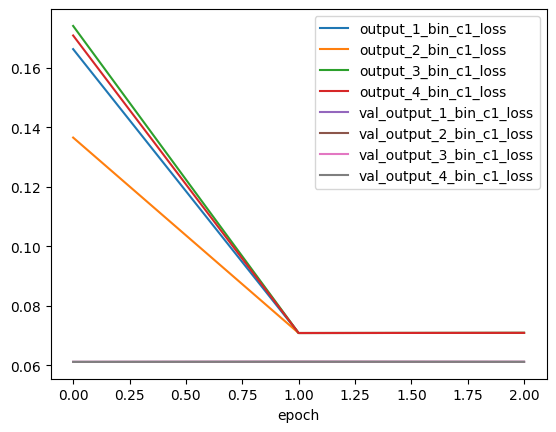

In [156]:
df_history.plot("epoch",bin_loss_list)

<Axes: xlabel='epoch'>

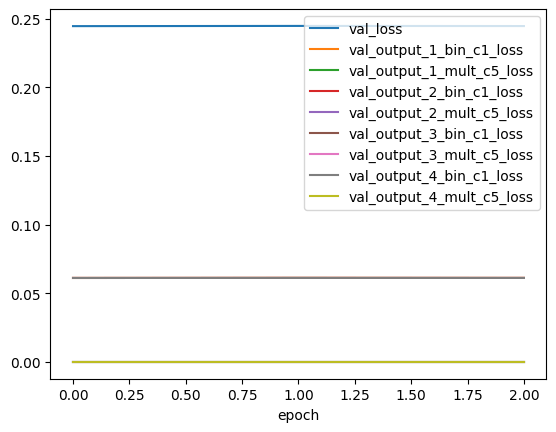

In [152]:
df_history.plot("epoch",val_loss_list)